In [ ]:
#%pip install rioxarray
#%pip install cartopy
%pip install netCDF4

In [1]:
from pathlib import Path

# General purpose data processing and visualization
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from collections import Counter

# Datetime data processing
#from datetime import date as d
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
from datetime import timedelta

# Geospatial data processing
import shapely
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Data loading

In [3]:
# NETCDF data
fpath_oisst = "sst_day_mean_1981-202502.nc"

In [4]:
# XARRAY DATASETS
ds_oisst = xr.open_dataset(fpath_oisst)

In [5]:
ds_oisst

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 16075, lat: 184, lon: 120)
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-04
  * lat      (lat) float32 736B -55.88 -55.62 -55.38 ... -10.62 -10.38 -10.12
  * lon      (lon) float32 480B 290.1 290.4 290.6 290.9 ... 319.4 319.6 319.9
Data variables:
    sst      (time, lat, lon) float32 1GB ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

## Data event

In [4]:
# Define the MHW peak event date
#MHW_pkDate01, MHW_stDate01, MHW_edDate01 = "2024-10-24", "2024-09-03", "2024-11-22"
MHW_pkDate01 = "2014-02-11"
MHW_pkDate02 = "2024-10-25"
MHW_pkDate03 = "2023-06-11"

# Define climatology
climY_start, climY_end = "1983-01-01", "2012-12-31" # from 1983 to 2012: 30 years

## OISST data processing

In [5]:
# ??
#list_CordsR = [(-38, -34), (-34, -20), (-34, -30), (-30, -20)]

# CORRECT OISST DATA COORDINATES
ds_oisst['lon'] = ds_oisst['lon']-360

# SELECT SST DATA
ds_oisst_sst = ds_oisst.sst

# FILTER DATA BY TIME RANGE
ds_oisst_time = ds_oisst_sst.sel(time=slice("1983-01-01", "2025-01-01"))
ds_oisst_latlon = ds_oisst_time.sel(lat=slice(-55, -10))

## ERA5 data processing

## MHW intensity processing (functions)

**NOTE**: The current analysis is constrained to MHW with intensity peak date +5 and -5 days in the same year. Next steps, solve this cases in different years

In [7]:
#
def get_Middate(date_str01, date_str02):
    d01 = dt.strptime(date_str01, "%Y-%m-%d")
    d02 = dt.strptime(date_str02, "%Y-%m-%d")

    mid_date = d01 + (d02 - d01) / 2

    return mid_date.strftime("%Y-%m-%d")

# Define a function to return dates +5 and -5 days from the MHW peak intensity date
def get_dates(date_str, window):
    '''
    The function takes the MHW peak intensity date, and returns
    the +5 and -5 days dates
    '''
    d = dt.strptime(date_str, "%Y-%m-%d")
    d_minus = (d - timedelta(days=window)).strftime("%Y-%m-%d")
    d_plus  = (d + timedelta(days=window)).strftime("%Y-%m-%d")
    return d_minus, d_plus

# 
def dates_climg(climY_start, climY_end, MHW_pkDateBef, MHW_pkDateAft):

    # Create dates copy
    dateBef_str = MHW_pkDateBef
    dateAft_str = MHW_pkDateAft

    # Get year dates
    dateBefY = int(dateBef_str[:4]) # int
    dateAftY = int(dateAft_str[:4]) # int

    # Get MM-DD dates
    dateBefMMDD = dateBef_str[-6:] # str
    dateAftMMDD = dateAft_str[-6:] # str

    # Define MM-DD
    mmdd_y1 = dateBefMMDD
    mmdd_y2 = dateAftMMDD

    # Define years range
    range_y1 = int(climY_start[:4])
    range_y2 = int(climY_end[:4]) + 1 # Add 1 extra year because range settings

    # Create list of tuples with dates +5 and -5 days during the base period
    listTup_dates = []

    # Iterate and get tuples of dates in the climatology period
    for y in range(range_y1, range_y2):
        if dateBefY != dateAftY: 
            listTup_dates.append((str(y-1)+mmdd_y1, str(y)+mmdd_y2))
        else:
            listTup_dates.append((str(y)+mmdd_y1, str(y)+mmdd_y2))

    return listTup_dates

In [8]:
def get_clim_90p_diff(ds_oisst_ipt, date, climY_start, climY_end, MHW_window = 5):
    
    # Filter data for mean climatology and threshold (climatology period)
    ds_oisst_filt = ds_oisst_ipt.copy().sel(time=slice(climY_start, climY_end))
    
    # Get +5 days and -5 days dates from the peak intensity date
    MHW_pkDateBef, MHW_pkDateAft = get_dates(date, MHW_window)
    
    # Create list of tuples with dates +5 and -5 days during the base period
    listTup_dates = dates_climg(climY_start, climY_end, MHW_pkDateBef, MHW_pkDateAft)
    
    # Iterate over each year in the climatology period and get the scenes between dates +5 and -5 days
    arrays = []   # Temporary list of scenes between the dates 
    
    for dates in listTup_dates:
        #da_day = process_day(date)   # this returns a DataArray
        oisst_sliced = ds_oisst_filt.copy().sel(time=slice(dates[0], dates[1]))
        arrays.append(oisst_sliced)
    
    # Stack all the scenes
    stacked = xr.concat(arrays, dim="time")
    
    # Compute climatology, 90th percentile and difference
    stackedClim90th = stacked.mean(dim="time")
    stacked90th = stacked.quantile(0.90, dim="time")
    climThresh_diff = stacked90th - stackedClim90th

    return stackedClim90th, stacked90th, climThresh_diff

def get_MHWint(ds_oisst_ipt, date, climY_start, climY_end, mask = True):

    # Get climatology SST, 90th percentile SST and difference
    stackedClim90th, stacked90th, climThresh_diff = get_clim_90p_diff(ds_oisst_ipt, date, climY_start, climY_end)
    
    # Get peak intensity MHW scene
    ds_oisst_pkDate = ds_oisst_ipt.copy().sel(time=date)
    
    # Get intensity (T MHW date-T 90th percentile) and mask negative values
    ds_IpkDate = ds_oisst_pkDate - stacked90th

    # Mask negative values
    if mask == True:
        ds_IpkDate = ds_IpkDate.where(ds_IpkDate > 0)

    return ds_IpkDate, climThresh_diff


def get_MHWint_cat(ds_oisst_ipt, date, climY_start, climY_end):

    # Get MHW intensity and difference 90th p-climatology 
    ds_IpkDate, climThresh_diff = get_MHWint(ds_oisst_ipt, date, climY_start, climY_end)

    # Convert intensity continous values to discrete
    climThresh_diff_mask = climThresh_diff.where(ds_IpkDate > 0) ## Mask areas with negative data
    
    ratio = ds_IpkDate / climThresh_diff_mask ## Set the ratio intensity/(thresh-clim)
    
    ds_IpkDate_cat = xr.full_like(ratio, fill_value=np.nan) ## Initialize the categorical dataset with nan values
    
    ## fill with categorical data
    ds_IpkDate_cat = xr.where(ratio >= 3, 4, ds_IpkDate_cat)
    ds_IpkDate_cat = xr.where((ratio >= 2) & (ratio < 3), 3, ds_IpkDate_cat)
    ds_IpkDate_cat = xr.where((ratio >= 1) & (ratio < 2), 2, ds_IpkDate_cat)
    ds_IpkDate_cat = xr.where((ratio >= 0) & (ratio < 1), 1, ds_IpkDate_cat)
    
    return ds_IpkDate_cat

## Plot maps

In [11]:
def plot_MHW_IntCat(ax_idx, ds_oisst_ipt, date, climY_start, climY_end, MHW_format, y_lim, x_lim, wind = False, wind_data_u = None, wind_data_v = None):
    
    if MHW_format == "intensity":
        ds_IpkDate, climThresh_diff = get_MHWint(ds_oisst_ipt, date, climY_start, climY_end)

        ds_IpkDate.plot(ax = ax_idx, cmap="Reds", 
                        vmin = 0, vmax = 4,
                        cbar_kwargs={'label': 'Intensidad MHW (°C)'})
    
        ax_idx.set_title(f"MHW {date} (Int. continua)")
        
    elif MHW_format == "category":
        ds_IpkDate_cat = get_MHWint_cat(ds_oisst_ipt, date, climY_start, climY_end)

        # Define custom colors and boundaries
        colors = ['#440154', '#21918c', '#5ec962', '#fde725'] # One more boundary than colors
        bounds = [0, 1.01, 2.01, 3.01, 4.01]

        # Create a discrete colormap and a normalization object
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        ds_IpkDate_cat.plot.pcolormesh(
            ax = ax_idx,
            cmap=cmap,
            norm=norm,
            cbar_kwargs={'ticks': bounds, 
                         'label': 'Categoría MHW',
                         'format': mticker.FormatStrFormatter('%.0f')}
        )
            
        ax_idx.set_title(f"MHW {date} (Int. categorizada)")
    else:
        print("No accepted displaying format (MHW_format)")

    # Coastlines & borders
    
    # Plot configuration
    ax_idx.set_xlabel("Longitud (°)", fontsize = 13)
    ax_idx.set_ylabel("Latitud (°)", fontsize = 13)
    ax_idx.set_xticks(np.arange(-65, -30, 5), crs=ccrs.PlateCarree())  # Longitude ticks
    ax_idx.set_yticks(np.arange(-45, -15, 5), crs=ccrs.PlateCarree())  # Latitude ticks
    ax_idx.set_ylim(y_lim[0], y_lim[1])
    ax_idx.set_xlim(x_lim[0], x_lim[1])

## Visualize MHW

c:\Users\win10\anaconda3\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
c:\Users\win10\anaconda3\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


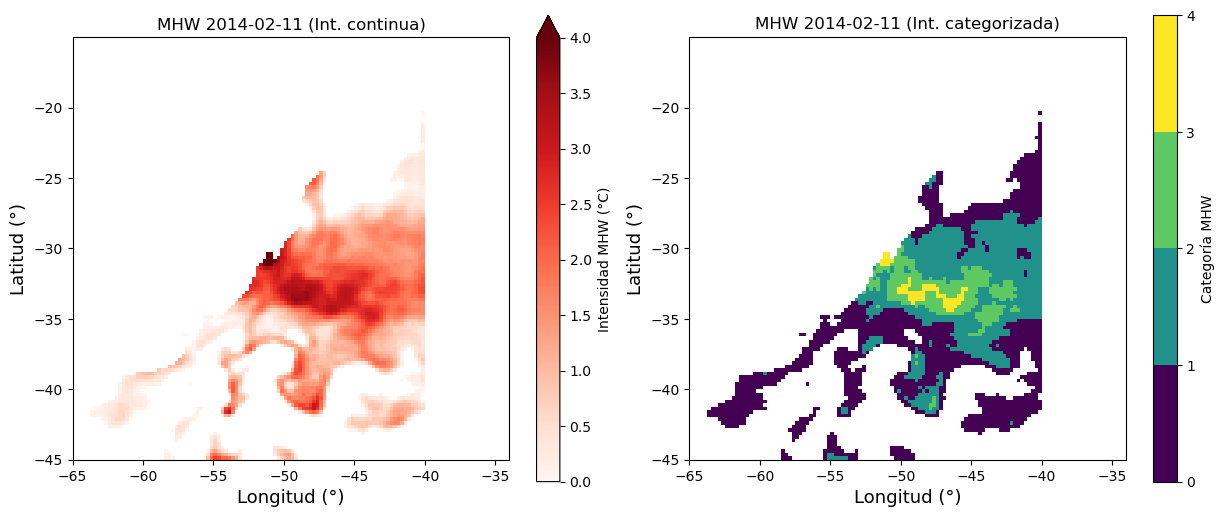

In [12]:
# VISUALIZE EVENT MAX INTENSITY
fig, ax = plt.subplots(1, 2, figsize=(16/1.3, 6.5/1.3),
                       subplot_kw={'projection': ccrs.PlateCarree()})

y_lim = [-45, -15]
x_lim = [-65, -34]

# ROW 1
plot_MHW_IntCat(ax[0], ds_oisst_latlon, 
                MHW_pkDate01, 
                climY_start, climY_end, "intensity", y_lim, x_lim)
plot_MHW_IntCat(ax[1], ds_oisst_latlon, 
                MHW_pkDate01, 
                climY_start, climY_end, "category", y_lim, x_lim,)


plt.tight_layout(pad=0.2)
plt.subplots_adjust(hspace=0.2)  # vertical space between rows

plt.show()

/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


2024-10-25
2024-10-25


/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


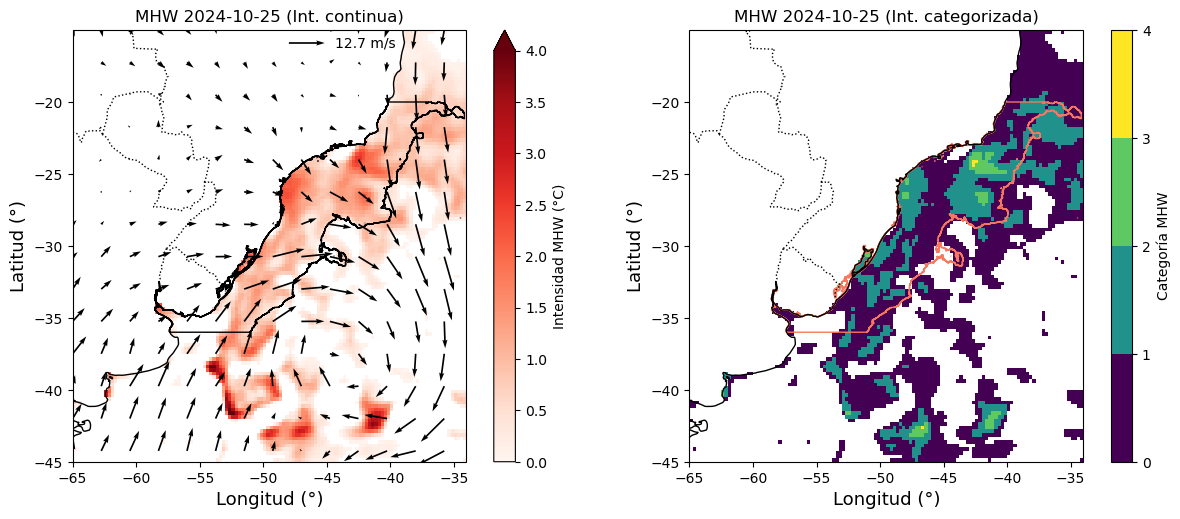

In [23]:
# VISUALIZE EVENT MAX DURATION
fig, ax = plt.subplots(1, 2, figsize=(16/1.3, 6.5/1.3),
                       subplot_kw={'projection': ccrs.PlateCarree()})

y_lim = [-45, -15]
x_lim = [-65, -34]

# ROW 1
plot_MHW_IntCat(ax[0], ds_oisst_latlon, 
                MHW_pkDate02, 
                climY_start, climY_end, "intensity", y_lim, x_lim,
                wind = True, wind_data_u = wind_u, wind_data_v = wind_v)
plot_MHW_IntCat(ax[1], ds_oisst_latlon, 
                MHW_pkDate02, 
                climY_start, climY_end, "category", y_lim, x_lim,)


plt.tight_layout(pad=0.2)
plt.subplots_adjust(hspace=0.2)  # vertical space between rows

plt.show()

/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


2023-06-11
2023-06-11


/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


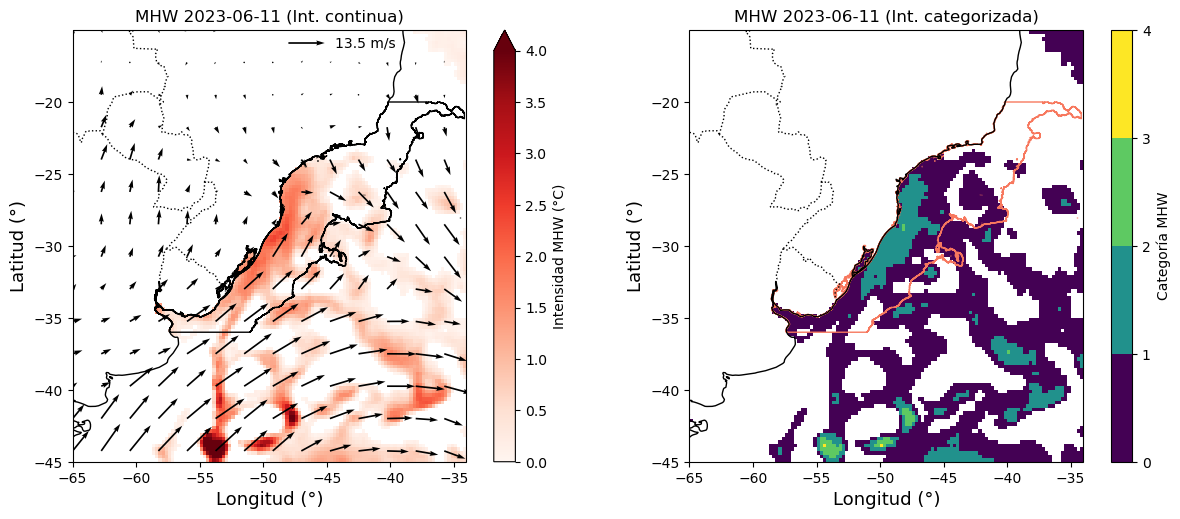

In [24]:
# VISUALIZE RANDOM EVENT: POTENTIAL FLOODS IN RIO DE JANEIRO 2023
fig, ax = plt.subplots(1, 2, figsize=(16/1.3, 6.5/1.3),
                       subplot_kw={'projection': ccrs.PlateCarree()})

y_lim = [-45, -15]
x_lim = [-65, -34]

# ROW 1
plot_MHW_IntCat(ax[0], ds_oisst_latlon, 
                MHW_pkDate03, 
                climY_start, climY_end, "intensity", y_lim, x_lim,
                wind = True, wind_data_u = wind_u, wind_data_v = wind_v)
plot_MHW_IntCat(ax[1], ds_oisst_latlon, 
                MHW_pkDate03, 
                climY_start, climY_end, "category", y_lim, x_lim,)


plt.tight_layout(pad=0.2)
plt.subplots_adjust(hspace=0.2)  # vertical space between rows

plt.show()

/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


2024-09-03
2024-09-03


/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


2024-09-28
2024-09-28


/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


2024-10-24
2024-10-24


/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


2024-11-22
2024-11-22


/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


2024-11-07
2024-11-07


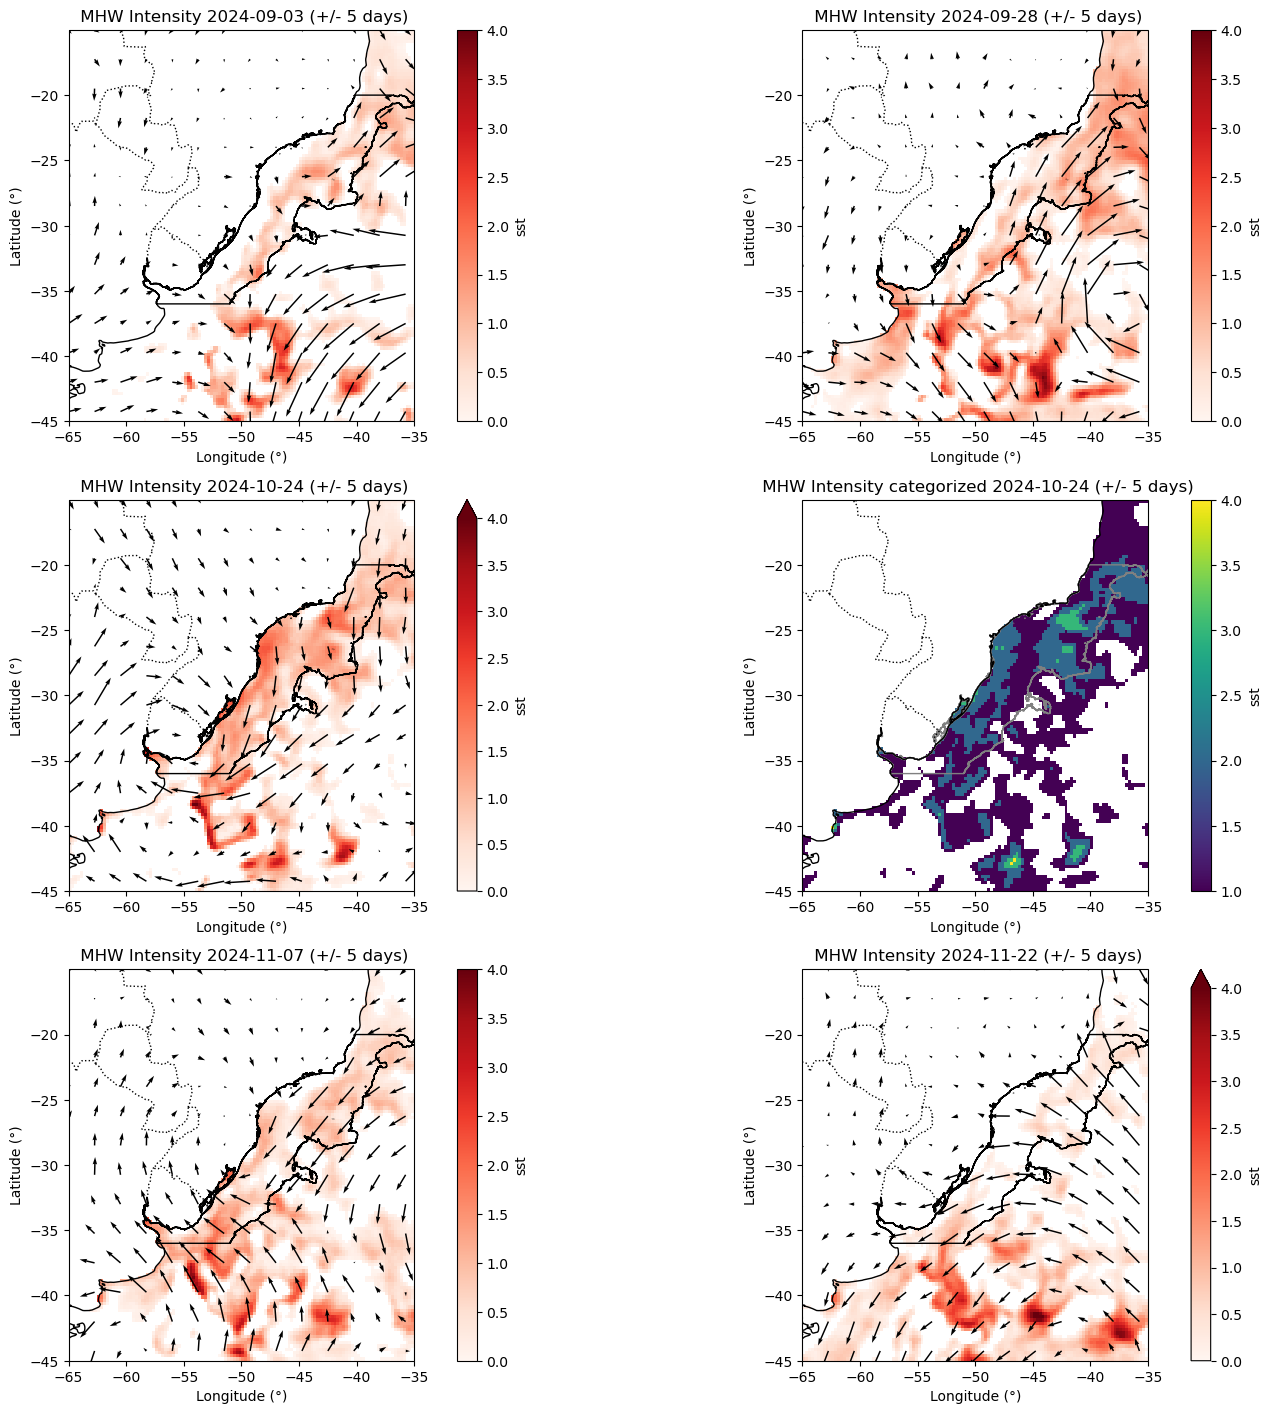

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(16, 14),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#(ax_idx, ds_oisst_ipt, date, climY_start, climY_end, MHW_format, y_lim, x_lim, wind = False, wind_data_u = None, wind_data_v = None):

#y_lim = [-40, -19]
#x_lim = [-65, -38]
y_lim = [-45, -15]
x_lim = [-65, -35]

#[-15, -65, -45, -35]

# ROW 0
plot_MHW_IntCat(ax[0, 0], ds_oisst_latlon, 
                MHW_stDate, 
                climY_start, climY_end, "intensity", y_lim, x_lim,
                wind = True, wind_data_u = wind_u, wind_data_v = wind_v)
plot_MHW_IntCat(ax[0, 1], ds_oisst_latlon, 
                get_Middate(MHW_stDate, MHW_pkDate), 
                climY_start, climY_end, "intensity", y_lim, x_lim,
                wind = True, wind_data_u = wind_u, wind_data_v = wind_v)

# ROW 1
plot_MHW_IntCat(ax[1, 0], ds_oisst_latlon, 
                MHW_pkDate, 
                climY_start, climY_end, "intensity", y_lim, x_lim,
                wind = True, wind_data_u = wind_u, wind_data_v = wind_v)
plot_MHW_IntCat(ax[1, 1], ds_oisst_latlon, 
                MHW_pkDate, 
                climY_start, climY_end, "category", y_lim, x_lim,)

# ROW 2
plot_MHW_IntCat(ax[2, 1], ds_oisst_latlon, 
                MHW_edDate, 
                climY_start, climY_end, "intensity", y_lim, x_lim,
                wind = True, wind_data_u = wind_u, wind_data_v = wind_v)
plot_MHW_IntCat(ax[2, 0], ds_oisst_latlon, 
                get_Middate(MHW_pkDate, MHW_edDate), 
                climY_start, climY_end, "intensity", y_lim, x_lim,
                wind = True, wind_data_u = wind_u, wind_data_v = wind_v)

plt.tight_layout(pad=0.2)
plt.subplots_adjust(hspace=0.2)  # vertical space between rows

plt.show()